# 02 - Neural Network Fundamentals

**Learning Objectives:**
After completing this notebook, you will understand:
- How perceptrons work as the building blocks of neural networks
- The role of activation functions in introducing non-linearity
- How feedforward networks process information layer by layer
- Different loss functions and when to use them
- The backpropagation algorithm for training neural networks
- Various optimization techniques for efficient learning

**Why Neural Networks Matter for LLMs:**
Large Language Models like GPT are built on neural network foundations. Understanding these basics is crucial because:
- Transformers (used in LLMs) are specialized neural networks
- The same optimization principles apply to training massive language models
- Activation functions and loss functions are fundamental to all deep learning

## Topics Covered:
- **Perceptrons**: The simplest neural network unit
- **Activation Functions**: Mathematical functions that add non-linearity
- **Feedforward Networks**: Multi-layer networks for complex pattern recognition
- **Loss Functions**: How we measure and minimize prediction errors
- **Backpropagation**: The algorithm that enables learning
- **Optimization**: Techniques for efficient parameter updates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple
import math

# Set random seed for reproducibility - ensures consistent results across runs
np.random.seed(42)

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1. Perceptrons - The Foundation of Neural Networks

**What is a Perceptron?**
A perceptron is the simplest type of artificial neuron. It:
- Takes multiple inputs (features)
- Multiplies each input by a weight
- Adds a bias term
- Applies a threshold function to make a binary decision

**Mathematical Formula:**
```
output = 1 if (w₁x₁ + w₂x₂ + ... + wₙxₙ + bias) > 0 else 0
```

**Key Concepts:**
- **Weights**: Determine the importance of each input
- **Bias**: Shifts the decision boundary
- **Learning**: Adjusting weights and bias based on errors

**Limitations:**
- Can only learn linearly separable patterns
- Cannot solve XOR problem (requires multiple layers)

In [2]:
class Perceptron:
    """
    Simple perceptron implementation for binary classification.
    
    The perceptron learns by adjusting weights when it makes mistakes:
    - If prediction is correct: no change
    - If prediction is wrong: adjust weights in the direction of the error
    """
    
    def __init__(self, input_size: int, learning_rate: float = 0.01):
        # Initialize weights randomly (small values to avoid saturation)
        self.weights = np.random.randn(input_size) * 0.1
        # Initialize bias to zero
        self.bias = 0.0
        # Learning rate controls how big steps we take during learning
        self.learning_rate = learning_rate
    
    def forward(self, x: np.ndarray) -> float:
        """
        Forward pass: compute weighted sum of inputs plus bias.
        This is the linear combination before applying threshold.
        """
        return np.dot(x, self.weights) + self.bias
    
    def predict(self, x: np.ndarray) -> int:
        """
        Make binary prediction using step function.
        Returns 1 if weighted sum > 0, otherwise 0.
        """
        return 1 if self.forward(x) > 0 else 0
    
    def train_step(self, x: np.ndarray, y: int) -> float:
        """
        Single training step using perceptron learning rule.
        
        Learning rule: Δw = η × error × input
        where η is learning rate, error = (target - prediction)
        """
        prediction = self.predict(x)
        error = y - prediction
        
        # Update weights: move in direction that reduces error
        self.weights += self.learning_rate * error * x
        # Update bias: same rule but input is always 1
        self.bias += self.learning_rate * error
        
        return abs(error)  # Return absolute error for monitoring

# Demonstrate perceptron learning on AND gate
print("=== PERCEPTRON LEARNING DEMONSTRATION ===")
print("Task: Learn the AND gate logic function")
print("AND gate truth table:")
print("Input (x1, x2) -> Output")
print("(0, 0) -> 0")
print("(0, 1) -> 0")
print("(1, 0) -> 0")
print("(1, 1) -> 1")
print()

# Training data for AND gate
X_and = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([0, 0, 0, 1])

# Create perceptron with 2 inputs
perceptron = Perceptron(input_size=2, learning_rate=0.1)

print(f"Initial weights: {perceptron.weights}")
print(f"Initial bias: {perceptron.bias}")
print()

# Training loop
epochs = 100
print("Training progress:")
for epoch in range(epochs):
    total_error = 0
    # Train on each example
    for x, y in zip(X_and, y_and):
        error = perceptron.train_step(x, y)
        total_error += error
    
    # Print progress every 10 epochs
    if epoch % 10 == 0 or total_error == 0:
        print(f"Epoch {epoch:2d}: Total error = {total_error}")
    
    # Stop if perfect classification achieved
    if total_error == 0:
        print(f"✓ Converged after {epoch + 1} epochs!")
        break

print()
print(f"Final weights: {perceptron.weights}")
print(f"Final bias: {perceptron.bias}")
print()

# Test the trained perceptron
print("=== TESTING RESULTS ===")
print("Input -> True | Predicted | Correct?")
print("-" * 35)
for x, y_true in zip(X_and, y_and):
    y_pred = perceptron.predict(x)
    correct = "✓" if y_pred == y_true else "✗"
    print(f"{x} ->   {y_true}   |     {y_pred}     |    {correct}")

=== PERCEPTRON LEARNING DEMONSTRATION ===
Task: Learn the AND gate logic function
AND gate truth table:
Input (x1, x2) -> Output
(0, 0) -> 0
(0, 1) -> 0
(1, 0) -> 0
(1, 1) -> 1

Initial weights: [ 0.04967142 -0.01382643]
Initial bias: 0.0

Training progress:
Epoch  0: Total error = 2
Epoch  5: Total error = 0
✓ Converged after 6 epochs!

Final weights: [0.14967142 0.08617357]
Final bias: -0.2

=== TESTING RESULTS ===
Input -> True | Predicted | Correct?
-----------------------------------
[0 0] ->   0   |     0     |    ✓
[0 1] ->   0   |     0     |    ✓
[1 0] ->   0   |     0     |    ✓
[1 1] ->   1   |     1     |    ✓


## 2. Activation Functions - Adding Non-linearity

**Why Activation Functions?**
Without activation functions, neural networks would just be linear transformations.
No matter how many layers you stack, the result would still be linear!

**Key Properties:**
- **Non-linearity**: Enables learning complex patterns
- **Differentiability**: Required for backpropagation
- **Range**: Output range affects network behavior
- **Computational efficiency**: Important for large networks

**Common Activation Functions:**
- **Sigmoid**: σ(x) = 1/(1+e^(-x)) - Outputs between 0 and 1
- **Tanh**: tanh(x) - Outputs between -1 and 1, zero-centered
- **ReLU**: max(0,x) - Simple, fast, helps with vanishing gradients
- **GELU**: Used in modern transformers like BERT and GPT
- **Softmax**: Converts logits to probabilities (sum = 1)

=== ACTIVATION FUNCTIONS VISUALIZATION ===


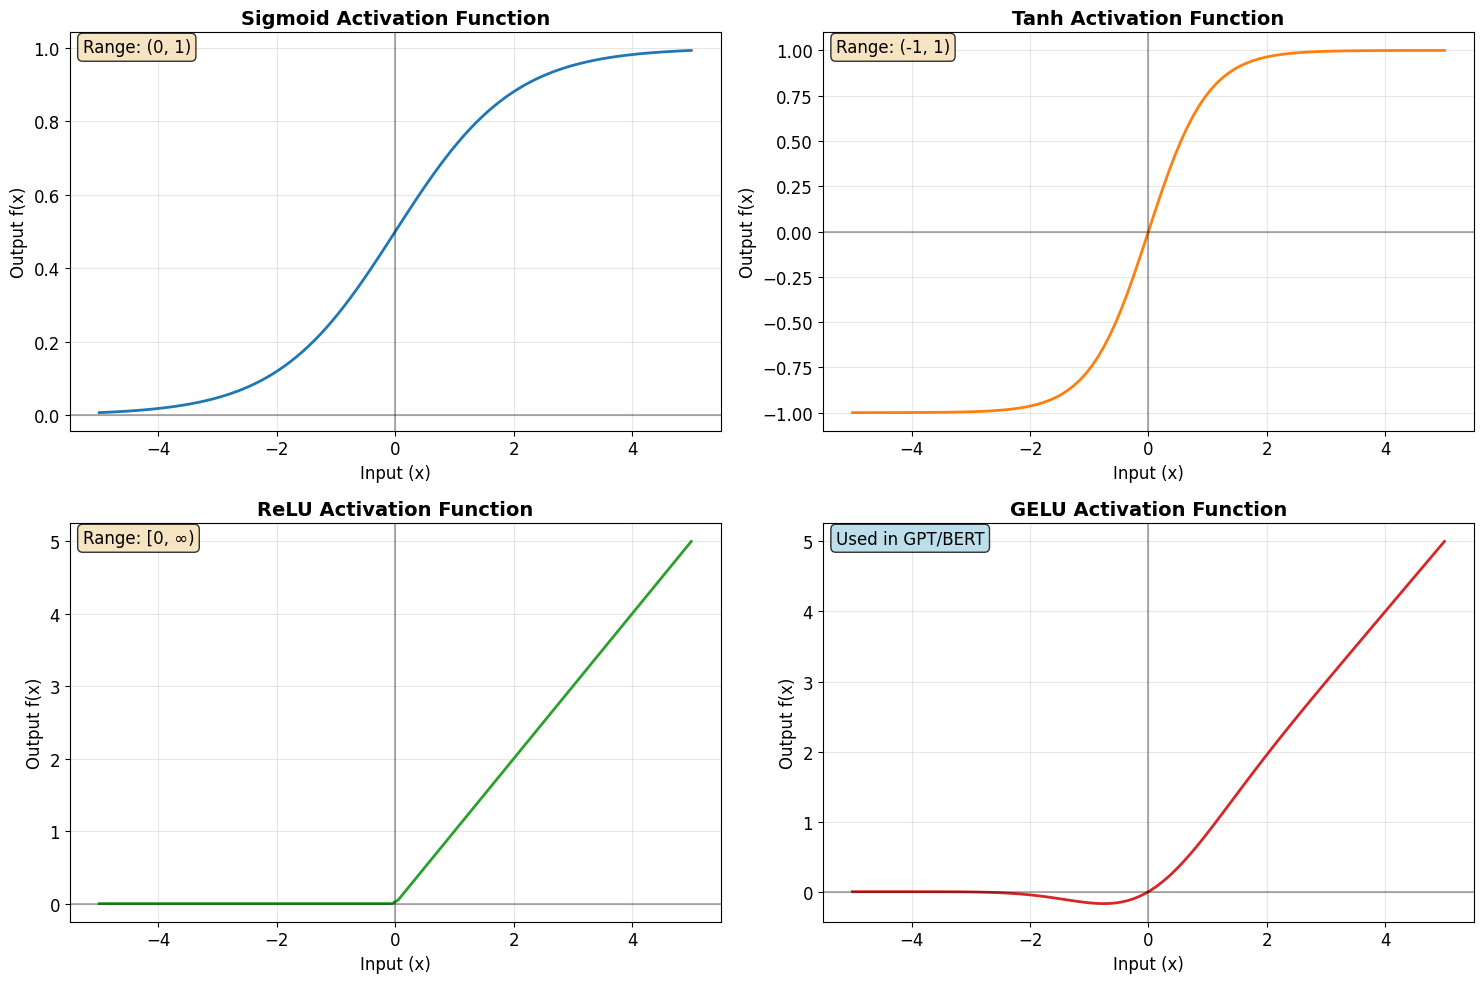


=== ACTIVATION FUNCTION COMPARISON ===
Input values: [-2 -1  0  1  2]
--------------------------------------------------
Sigmoid : [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
Tanh    : [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]
ReLU    : [0 0 0 1 2]
GELU    : [-0.04540231 -0.15880801  0.          0.84119199  1.95459769]

Key Observations:
- Sigmoid: Always positive, saturates at extremes
- Tanh: Zero-centered, still saturates
- ReLU: Simple threshold, no saturation for positive values
- GELU: Smooth, used in state-of-the-art language models


In [3]:
class ActivationFunctions:
    """
    Collection of activation functions and their derivatives.
    
    Each function includes:
    - The activation function itself
    - Its derivative (needed for backpropagation)
    - Numerical stability considerations
    """
    
    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        """
        Sigmoid activation: σ(x) = 1/(1+e^(-x))
        
        Properties:
        - Range: (0, 1)
        - Smooth, differentiable
        - Problem: Vanishing gradients for large |x|
        - Use case: Binary classification output
        """
        # Clip x to prevent overflow (exp(-500) ≈ 0, exp(500) ≈ ∞)
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative(x: np.ndarray) -> np.ndarray:
        """
        Derivative of sigmoid: σ'(x) = σ(x)(1-σ(x))
        Convenient property: derivative in terms of function value
        """
        s = ActivationFunctions.sigmoid(x)
        return s * (1 - s)
    
    @staticmethod
    def tanh(x: np.ndarray) -> np.ndarray:
        """
        Hyperbolic tangent: tanh(x) = (e^x - e^(-x))/(e^x + e^(-x))
        
        Properties:
        - Range: (-1, 1)
        - Zero-centered (better than sigmoid)
        - Still suffers from vanishing gradients
        - Use case: Hidden layers in small networks
        """
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x: np.ndarray) -> np.ndarray:
        """
        Derivative of tanh: tanh'(x) = 1 - tanh^2(x)
        """
        return 1 - np.tanh(x) ** 2
    
    @staticmethod
    def relu(x: np.ndarray) -> np.ndarray:
        """
        Rectified Linear Unit: ReLU(x) = max(0, x)
        
        Properties:
        - Range: [0, ∞)
        - Computationally efficient
        - Helps with vanishing gradient problem
        - Problem: "Dead neurons" (always output 0)
        - Use case: Most popular for hidden layers
        """
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x: np.ndarray) -> np.ndarray:
        """
        Derivative of ReLU: 1 if x > 0, else 0
        Note: Undefined at x=0, but we use 0 in practice
        """
        return (x > 0).astype(float)
    
    @staticmethod
    def gelu(x: np.ndarray) -> np.ndarray:
        """
        Gaussian Error Linear Unit (GELU)
        
        Properties:
        - Smooth approximation to ReLU
        - Used in BERT, GPT, and other transformers
        - Better performance than ReLU in many cases
        - Formula: GELU(x) = x * Φ(x) where Φ is CDF of standard normal
        """
        # Approximation: GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x^3)))
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
    
    @staticmethod
    def softmax(x: np.ndarray) -> np.ndarray:
        """
        Softmax activation: converts logits to probabilities
        
        Properties:
        - Outputs sum to 1
        - All outputs are positive
        - Amplifies differences between inputs
        - Use case: Multi-class classification output
        """
        # Subtract max for numerical stability (prevents overflow)
        # This doesn't change the result due to softmax properties
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Visualize activation functions to understand their behavior
print("=== ACTIVATION FUNCTIONS VISUALIZATION ===")
x = np.linspace(-5, 5, 100)  # Input range from -5 to 5
activations = ActivationFunctions()

plt.figure(figsize=(15, 10))

# Plot activation functions
functions = [
    ('Sigmoid', activations.sigmoid),
    ('Tanh', activations.tanh),
    ('ReLU', activations.relu),
    ('GELU', activations.gelu)
]

for i, (name, func) in enumerate(functions, 1):
    plt.subplot(2, 2, i)
    y = func(x)
    plt.plot(x, y, label=name, linewidth=2, color=f'C{i-1}')
    plt.title(f'{name} Activation Function', fontsize=14, fontweight='bold')
    plt.xlabel('Input (x)', fontsize=12)
    plt.ylabel('Output f(x)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Add range information
    if name == 'Sigmoid':
        plt.text(0.02, 0.95, 'Range: (0, 1)', transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    elif name == 'Tanh':
        plt.text(0.02, 0.95, 'Range: (-1, 1)', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    elif name == 'ReLU':
        plt.text(0.02, 0.95, 'Range: [0, ∞)', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    elif name == 'GELU':
        plt.text(0.02, 0.95, 'Used in GPT/BERT', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Compare activation function properties with numerical examples
print("\n=== ACTIVATION FUNCTION COMPARISON ===")
test_input = np.array([-2, -1, 0, 1, 2])
print(f"Input values: {test_input}")
print("-" * 50)

for name, func in functions:
    output = func(test_input)
    print(f"{name:8}: {output}")

print("\nKey Observations:")
print("- Sigmoid: Always positive, saturates at extremes")
print("- Tanh: Zero-centered, still saturates")
print("- ReLU: Simple threshold, no saturation for positive values")
print("- GELU: Smooth, used in state-of-the-art language models")

## 3. Feedforward Neural Networks - Multi-layer Learning

**What are Feedforward Networks?**
Multi-layer networks where information flows in one direction:
Input → Hidden Layer(s) → Output Layer

**Key Components:**
- **Input Layer**: Receives the data
- **Hidden Layer(s)**: Extract features and patterns
- **Output Layer**: Makes final predictions
- **Weights & Biases**: Learnable parameters

**Why Multiple Layers?**
- Single layer can only learn linear patterns
- Multiple layers can approximate any continuous function
- Each layer learns increasingly complex features

**Universal Approximation Theorem:**
A feedforward network with at least one hidden layer can approximate
any continuous function to arbitrary accuracy (given enough neurons).

Epoch 0, Loss: 1.3058, Accuracy: 0.3333
Epoch 100, Loss: 0.5952, Accuracy: 0.6800
Epoch 200, Loss: 0.4177, Accuracy: 0.8467
Epoch 300, Loss: 0.3026, Accuracy: 0.9067
Epoch 400, Loss: 0.2268, Accuracy: 0.9533
Epoch 500, Loss: 0.1791, Accuracy: 0.9600
Epoch 600, Loss: 0.1483, Accuracy: 0.9600
Epoch 700, Loss: 0.1273, Accuracy: 0.9733
Epoch 800, Loss: 0.1117, Accuracy: 0.9867
Epoch 900, Loss: 0.0998, Accuracy: 0.9867


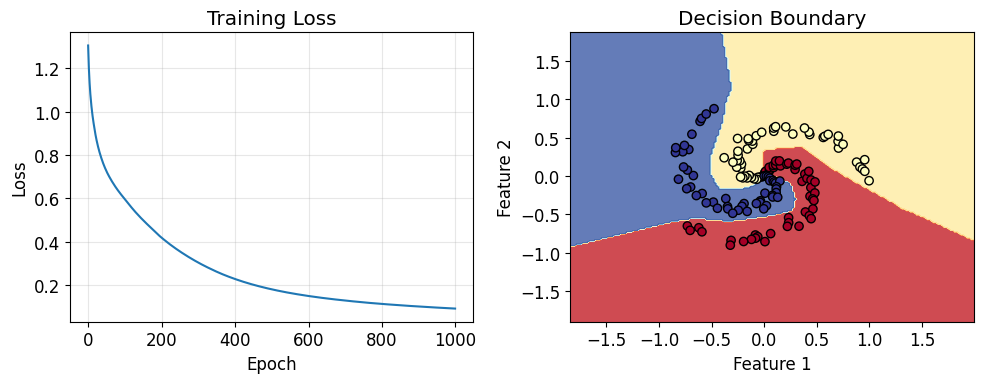


Final Accuracy: 0.9867


In [4]:
class FeedforwardNetwork:
    """Simple feedforward neural network."""
    
    def __init__(self, layer_sizes: List[int], activation: str = 'sigmoid'):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        for i in range(self.num_layers - 1):
            # Xavier initialization
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)
        
        # Set activation function
        self.activations = ActivationFunctions()
        if activation == 'sigmoid':
            self.activation = self.activations.sigmoid
            self.activation_derivative = self.activations.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = self.activations.tanh
            self.activation_derivative = self.activations.tanh_derivative
        elif activation == 'relu':
            self.activation = self.activations.relu
            self.activation_derivative = self.activations.relu_derivative
    
    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        """Forward pass through the network."""
        activations = [X]
        
        for i in range(self.num_layers - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            
            # Use softmax for output layer, activation function for hidden layers
            if i == self.num_layers - 2:  # Output layer
                a = self.activations.softmax(z)
            else:  # Hidden layers
                a = self.activation(z)
            
            activations.append(a)
        
        return activations[-1], activations
    
    def backward(self, X: np.ndarray, y: np.ndarray, learning_rate: float = 0.01):
        """Backward pass (backpropagation)."""
        m = X.shape[0]
        
        # Forward pass
        output, activations = self.forward(X)
        
        # Compute loss (cross-entropy)
        loss = -np.mean(np.sum(y * np.log(output + 1e-15), axis=1))
        
        # Backward pass
        deltas = [output - y]  # Error at output layer
        
        # Compute deltas for hidden layers
        for i in range(self.num_layers - 2, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.activation_derivative(activations[i])
            deltas.insert(0, delta)
        
        # Update weights and biases
        for i in range(self.num_layers - 1):
            self.weights[i] -= learning_rate * np.dot(activations[i].T, deltas[i]) / m
            self.biases[i] -= learning_rate * np.mean(deltas[i], axis=0, keepdims=True)
        
        return loss
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions."""
        output, _ = self.forward(X)
        return np.argmax(output, axis=1)

# Create a simple classification dataset
def create_spiral_dataset(n_points: int = 100, n_classes: int = 3) -> Tuple[np.ndarray, np.ndarray]:
    """Create a spiral dataset for classification."""
    X = np.zeros((n_points * n_classes, 2))
    y = np.zeros(n_points * n_classes, dtype=int)
    
    for class_num in range(n_classes):
        ix = range(n_points * class_num, n_points * (class_num + 1))
        r = np.linspace(0.0, 1, n_points)
        t = np.linspace(class_num * 4, (class_num + 1) * 4, n_points) + np.random.randn(n_points) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_num
    
    return X, y

# Generate dataset
X, y = create_spiral_dataset(n_points=50, n_classes=3)

# Convert labels to one-hot encoding
y_onehot = np.eye(3)[y]

# Create and train network
network = FeedforwardNetwork([2, 10, 10, 3], activation='relu')

# Training loop
losses = []
epochs = 1000

for epoch in range(epochs):
    loss = network.backward(X, y_onehot, learning_rate=0.1)
    losses.append(loss)
    
    if epoch % 100 == 0:
        predictions = network.predict(X)
        accuracy = np.mean(predictions == y)
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Plot decision boundary
plt.subplot(1, 2, 2)
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh_points = np.c_[xx.ravel(), yy.ravel()]
Z = network.predict(mesh_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

final_accuracy = np.mean(network.predict(X) == y)
print(f"\nFinal Accuracy: {final_accuracy:.4f}")

## Summary

**Neural Network Fundamentals Covered:**

- **Perceptrons**: Linear classifiers that learn simple patterns
- **Activation Functions**: Enable non-linear transformations (sigmoid, ReLU, GELU)
- **Feedforward Networks**: Multi-layer architectures for complex pattern recognition
- **Loss Functions**: Quantify prediction errors (MSE, cross-entropy)
- **Backpropagation**: Efficient gradient computation algorithm
- **Optimization**: Parameter update strategies (SGD, Adam)
- **Training Strategies**: Batch vs stochastic vs mini-batch approaches

**Foundation for LLMs:**
These concepts directly apply to Large Language Models:
- Transformer blocks contain feedforward layers
- Modern LLMs use GELU activations and Adam optimizers
- The same backpropagation principles scale to billions of parameters
- Understanding these basics is crucial for transformer architectures

**Next Steps:**
In subsequent notebooks, we'll build on these foundations to explore:
- Attention mechanisms and self-attention
- Transformer architecture
- Language modeling and tokenization
- Training large-scale models